In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv
/kaggle/input/plant-pathology-2020-fgvc7/test.csv
/kaggle/input/plant-pathology-2020-fgvc7/train.csv
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_782.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1356.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1767.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1424.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1622.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_882.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1254.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_265.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1079.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1794.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_487.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1787.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_627.jpg
/kaggle/input/plant-pathology

In [2]:
!pip install efficientnet

In [3]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.0 MB 2.8 MB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpi
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score
import itertools

import efficientnet.keras as efn
import tensorflow_addons as tfa
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Flatten,AvgPool2D,Activation,BatchNormalization,GlobalAveragePooling2D,GlobalMaxPooling2D,Conv2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import keras

Using TensorFlow backend.


In [5]:
train = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")
test = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")

In [6]:
train['image_id'] = train['image_id']+'.jpg'

In [7]:
train.shape

(1821, 5)

In [8]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


In [9]:
test['image_id'] = test['image_id']+'.jpg'

# data Augmentation

In [10]:
x_train,val = train_test_split(train,test_size = 0.1)

In [11]:
x_train.head()

,image_id,healthy,multiple_diseases,rust,scab
764,Train_764.jpg,0,0,1,0
142,Train_142.jpg,0,0,0,1
440,Train_440.jpg,0,0,1,0
78,Train_78.jpg,0,0,0,1
205,Train_205.jpg,0,0,1,0


In [12]:
col = x_train.drop('image_id',axis=1).columns.tolist()
col

['healthy', 'multiple_diseases', 'rust', 'scab']

In [13]:
gen_data = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=12,width_shift_range=0.15,height_shift_range=0.1,zoom_range=0.2,rescale=1/255,fill_mode='nearest')

In [14]:
gen_train = gen_data.flow_from_dataframe(x_train,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',target_size=(300,300),x_col='image_id',y_col = col,class_mode='raw',shuffle = False,subset='training',batch_size=20)

Found 1638 validated image filenames.


In [15]:
val_gen = gen_data.flow_from_dataframe(val,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',target_size=(300,300),x_col = 'image_id',y_col = col,class_mode='raw',shuffle = False,batch_size=20)

Found 183 validated image filenames.


In [16]:
gen_test = gen_data.flow_from_dataframe(test,directory='/kaggle/input/plant-pathology-2020-fgvc7/images/',target_size=(300,300),x_col='image_id',y_col=None,class_mode=None,shuffle=False,batch_size=20)

Found 1821 validated image filenames.


In [17]:
gen_train.next()[0].shape,gen_train.next()[1].shape

((20, 300, 300, 3), (20, 4))

In [18]:
model = efn.EfficientNetB4(weights='imagenet',include_top=False,input_shape=(300,300,3))

71892992/71892840 [==============================] - 1s 0us/step


In [19]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
pred = Dense(4,activation='softmax')(x)

In [20]:
model = Model(inputs = model.input,outputs = pred)

In [21]:
optimizer = RMSprop()

In [22]:
model.compile(optimizer=optimizer,loss = tfa.losses.SigmoidFocalCrossEntropy(),metrics = ['accuracy'])

In [23]:
true = val.iloc[:,1::].values

In [24]:
batch_size = 20

In [25]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

In [26]:
result=model.fit_generator(gen_train,epochs = 5,steps_per_epoch=gen_train.n/batch_size,validation_data=val_gen,validation_steps=val_gen.n/batch_size,callbacks=[lr_reduction])

Epoch 1/5
82/81 [==============================] - 274s 3s/step - loss: 0.1364 - accuracy: 0.7943 - val_loss: 0.0030 - val_accuracy: 0.9126
Epoch 2/5
82/81 [==============================] - 212s 3s/step - loss: 0.0931 - accuracy: 0.8669 - val_loss: 0.0065 - val_accuracy: 0.8852
Epoch 3/5
82/81 [==============================] - 216s 3s/step - loss: 0.0880 - accuracy: 0.8706 - val_loss: 0.1088 - val_accuracy: 0.4809
Epoch 4/5
82/81 [==============================] - 216s 3s/step - loss: 0.0693 - accuracy: 0.9017 - val_loss: 0.0167 - val_accuracy: 0.9399
Epoch 5/5
82/81 [==============================] - 215s 3s/step - loss: 0.0594 - accuracy: 0.9182 - val_loss: 0.0434 - val_accuracy: 0.7978


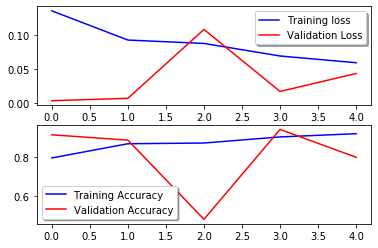

In [27]:
fig,ax = plt.subplots(2,1)

ax[0].plot(result.history['loss'],color = 'b',label = "Training loss")
ax[0].plot(result.history['val_loss'],color = 'r',label = "Validation Loss")
legend = ax[0].legend(loc='best',shadow = True)

ax[1].plot(result.history['accuracy'],color = 'b',label='Training Accuracy')
ax[1].plot(result.history['val_accuracy'],color='r',label = "Validation Accuracy")
legend = ax[1].legend(loc='best',shadow=True)

# PRediction

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [29]:
y_pred = model.predict_generator(val_gen,steps=val_gen.n/batch_size)
y_pred = y_pred.round().astype(int)

In [30]:
print(accuracy_score(true,y_pred))
print( )
print(f1_score(true,y_pred,average='macro'))
print( )
print(roc_auc_score(true,y_pred,average='macro'))

0.6557377049180327

0.5828668968511745

0.7513985986100034


In [31]:
y_test = model.predict(gen_test,steps = gen_test.n/batch_size)

In [32]:
y_test.shape

(1821, 4)

In [33]:
sub=pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [34]:
len(sub),len(y_test)

(1821, 1821)

In [35]:
for i,j in enumerate(['healthy','multiple_diseases','rust','scab']):
    sub[j]=y_test[:,i]

In [36]:
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.007033,0.015789,0.970509,0.006669
1,Test_1,0.415909,0.250997,0.237345,0.095749
2,Test_2,0.020799,0.034803,0.007559,0.936838
3,Test_3,0.579029,0.169889,0.159144,0.091937
4,Test_4,0.052984,0.238596,0.674867,0.033553


In [37]:
sub.to_csv("Submission.csv",index = False)